In [1]:
from astropy.io import fits
from astropy.table import Table
import astropy.units as u

import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve

import math as math

import warnings

import scipy.signal as sp

warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
#import fits file

#file_name = "12_21_F0799_EX_SPE_7500573_EXEELONEXEECHL_MRD_0035-0040"
file_name = "3_1_22_F0832_EX_SPE_7500571_EXEELONEXEECHL_MRD_0089-0091-0092-0093.fits"
#file_name = "3_4_22_F0835_EX_SPE_7500574_EXEELONEXEECHL_MRD_0069-0070-0071-0076.fits"

hduList = fits.open(file_name)

In [3]:
hduList.info()

Filename: 3_1_22_F0832_EX_SPE_7500571_EXEELONEXEECHL_MRD_0089-0091-0092-0093.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     558   (5527, 4)   float64   


In [4]:
#Size and shape of the original data
hduList[0].data.shape

(4, 5527)

In [5]:
#Diplay first 20 rows of header information
#hduList[0].header[0:20]

In [6]:
#Load an example HITRAN model for H2O at 300K
water_model = Table.read(
    "for_sean_H2O_1300to1800_300K_5.0e18_6kms.txt",
    format="ascii",
    names=("wavenumber", "flux"),
)

#inspect water model
water_model[0:20]

#Create new variables for wavelength in um
water_model["wavelength_um"] = 1 / water_model["wavenumber"] * 1e4 #convert water model units too

In [7]:
#Import Hitran Table

hitran = Table.read(
    "3_1_hitran.txt",
    format="ascii",
    names=("Wavenumber", "El", "A","gu","gl","S"),
)
hitran["Wavelength"] = 1 / hitran["Wavenumber"] * 1e4 #convert to wavelength

hitran["Eu"] = hitran["El"] + hitran["Wavenumber"]

hitran["Eu(K)"] = hitran["Eu"]*1.43879

hitran[-101:-1]

Wavenumber,El,A,gu,gl,S,Wavelength,Eu,Eu(K)
float64,float64,float64,int32,int32,float64,float64,float64,float64
1747.975981,2129.5992,0.0004026,27,27,8.614e-28,5.720902408669882,3877.575181,5579.01639467099
1747.976133,2512.3757,26.42,21,19,6.84e-24,5.720901911193316,4260.351833,6129.75161380207
1747.977427,382.5169,1.63e-07,33,27,2.079e-27,5.720897676100252,2130.494327,3065.33393274433
1748.103972,4856.2153,18.33,7,5,1.783e-29,5.720483541124292,6604.319272,9502.228525360879
1748.150229,4559.7076,1.15,57,57,3.85e-29,5.720332174037658,6307.857829,9075.682765786909
1748.15117,3317.2106,15.27,7,5,2.635e-26,5.720329094880278,5065.3617699999995,7287.991861058299
1748.183982,2512.2829,26.43,63,57,2.053e-23,5.720221728927842,4260.466882000001,6129.917145152781
1748.372101,5087.0171,2.671,19,19,2.296e-30,5.7196062521704585,6835.389201,9834.68962850679
1748.380349,3833.1444,0.3167,63,69,4.004e-28,5.719579269876592,5581.524749,8030.64199361371


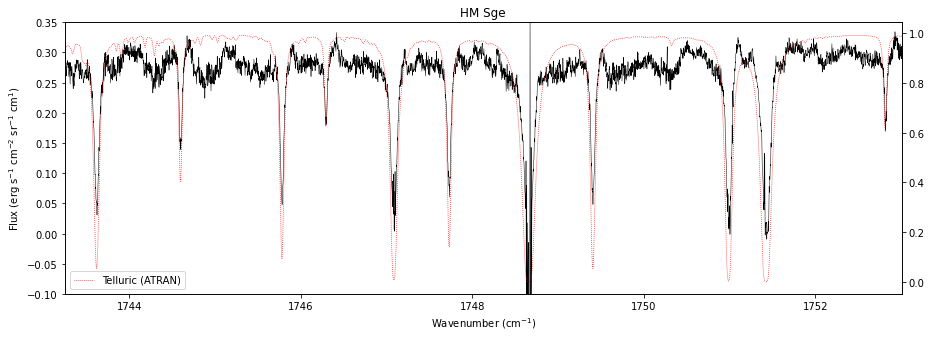

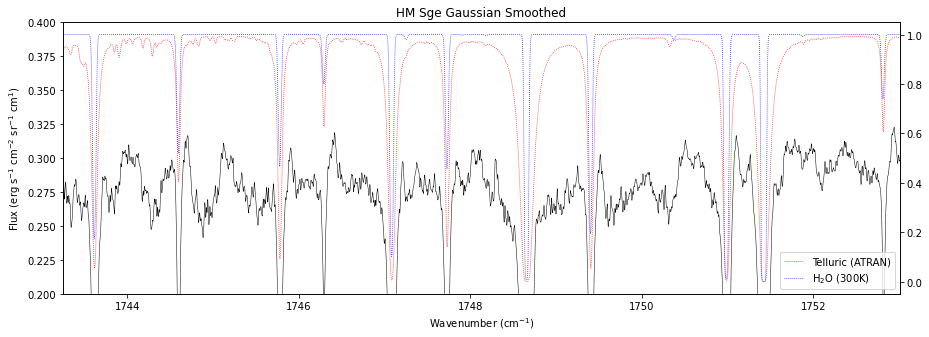

In [8]:
#Original Plot

#Data columns to variables with units
wavenumber = hduList[0].data[0].view()
flux_unit = u.erg * u.s ** (-1) * (u.cm) ** -2 * u.sr ** (-1)
flux = hduList[0].data[1].view()
original_flux = flux.view()
uncertainty = hduList[0].data[2].view() * flux_unit
atran = hduList[0].data[3].view()

#Gaussian smooth the data to visually highlight peaks
variance = 2
g = Gaussian1DKernel(stddev=variance)
gauss_flux = convolve(flux, g)

#Plot the whole spectrum
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax1.plot(wavenumber,  flux, lw=0.5, c="k")
ax2.plot(wavenumber, atran, lw=0.75, c="r", linestyle=":", label="Telluric (ATRAN)")
ax1.set_ylabel(r"Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ cm$^{1}$)")
ax1.set_xlabel(r"Wavenumber (cm$^{-1}$)")
ax1.set_xlim(min(wavenumber)+1, max(wavenumber)-1)
ax1.set_ylim(-.1,.35)
plt.legend()
plt.title("HM Sge")
plt.show()

#Plot the smoothed version
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax1.plot(wavenumber,  gauss_flux, lw=0.5, c="k")
ax2.plot(wavenumber, atran, lw=0.75, c="r", linestyle=":", label="Telluric (ATRAN)")
ax2.plot(
        water_model["wavenumber"],
        water_model["flux"],
        lw=0.75,
        c="b",
        linestyle=":",
        label=r"H$_2$O (300K)",
    )
ax1.set_ylabel(r"Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ cm$^{1}$)")
ax1.set_xlabel(r"Wavenumber (cm$^{-1}$)")
ax1.set_xlim(min(wavenumber)+1, max(wavenumber)-1)
ax1.set_ylim(.2,.4)
plt.legend()
plt.title("HM Sge Gaussian Smoothed")
plt.show()

In [9]:
#Function to set up the plots

#Convert wavenumber to wavelength
wavelength_um = 1 / wavenumber * 1e4  #convert wavenumber (cm^-1) to wavelength in um

#correction velocity
v_corrected = -19.35 #from exes velocity shift program

#correct for system velocities in the graph
watergraph = water_model["wavelength_um"]*(v_corrected/300000) + water_model["wavelength_um"]
#watergraph = water_model["wavelength_um"]

#Flux smoothing
flux = original_flux

def plot_window(xmin, xmax):
    #Create axes
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 1, 1)
    #create second axis to overplot ATRAN
    ax2 = ax1.twinx()
    #hide axis labels and ticks
    ax2.set_yticks([])
    #plot data
    ax1.plot(wavelength_um, flux, lw=0.5, c="k")
    #plot Atmospheric model (ATRAN)
    ax2.plot(
        wavelength_um, atran, lw=0.75, c="r", linestyle=":", label="Telluric (ATRAN)"
    )

    #Setup water model plot
    #ax2.plot(
     #   water_model["wavelength_um"],
      #  water_model["flux"],
       # lw=0.75,
        #c="b",
        #linestyle=":",
        #label=r"H$_2$O (300K)",
    #)

    #Plot labels
    ax1.set_ylabel(r"Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ cm$^{1}$)")
    ax1.set_xlabel(r"Wavelength ($\mu$m)")

    plt.legend(loc="lower right")
    plt.title("HM Sge 3-1-22")
    return fig, ax1, ax2

#Min and max flux
print(min(flux))
maxF = max(flux)
print(maxF)
print(max(wavelength_um))

-0.5800704956054688
0.8254295587539673
5.739718480541255


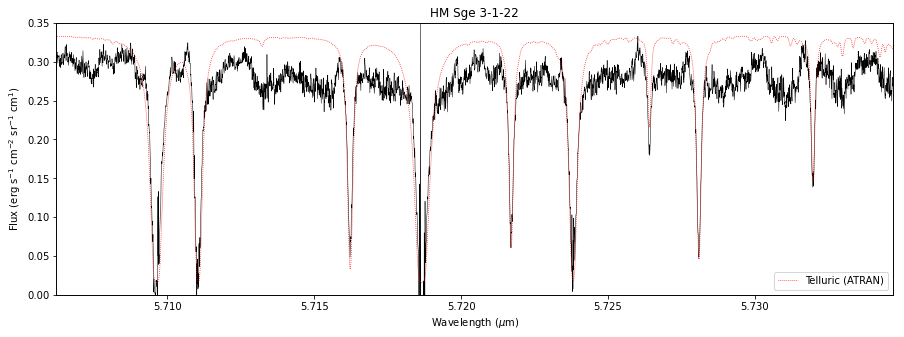

In [10]:
#Plot the full spectrum
minW = min(wavelength_um)+.005
maxW = max(wavelength_um)-.005

#Calls the previously created plot_window function and plots the full range of the data set
fig, ax1, ax2 = plot_window(5.8, 5.6) 

#Optional manual y range
ax1.set_ylim(0, .35) 
ax1.set_xlim(minW, maxW) 



plt.show()

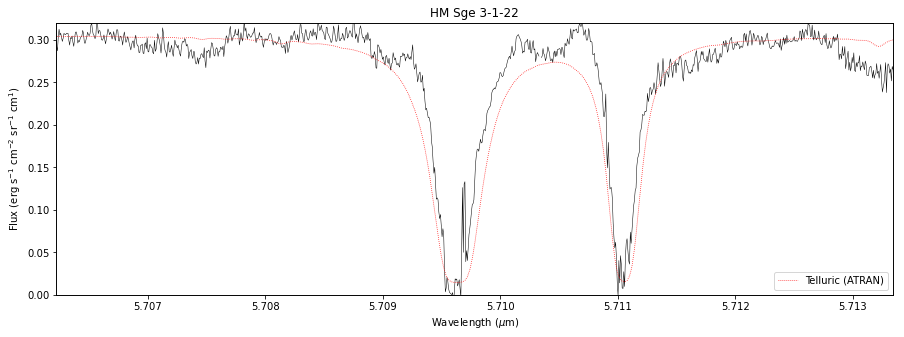

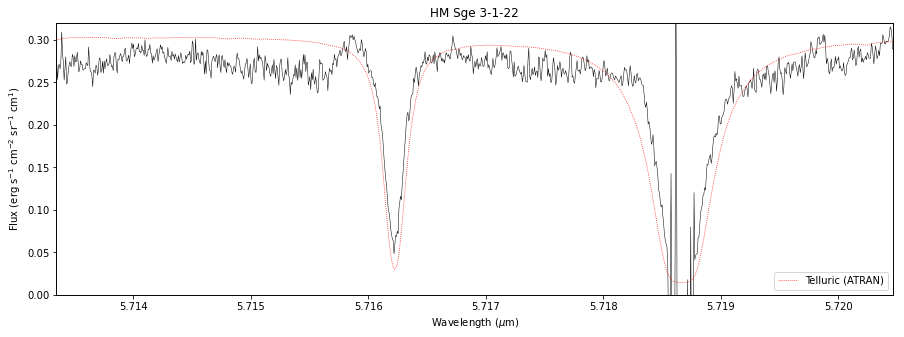

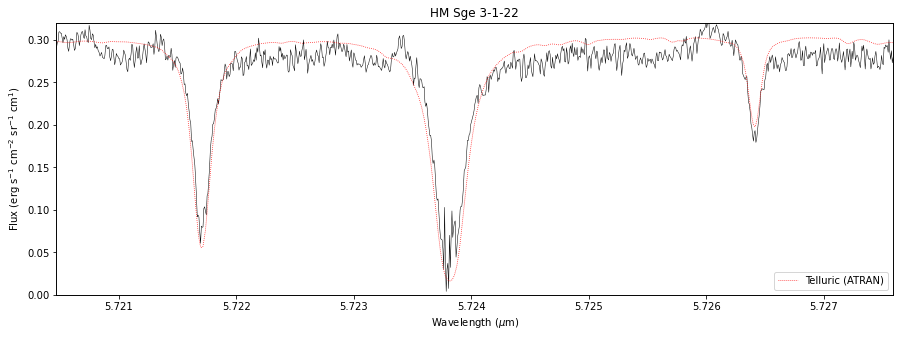

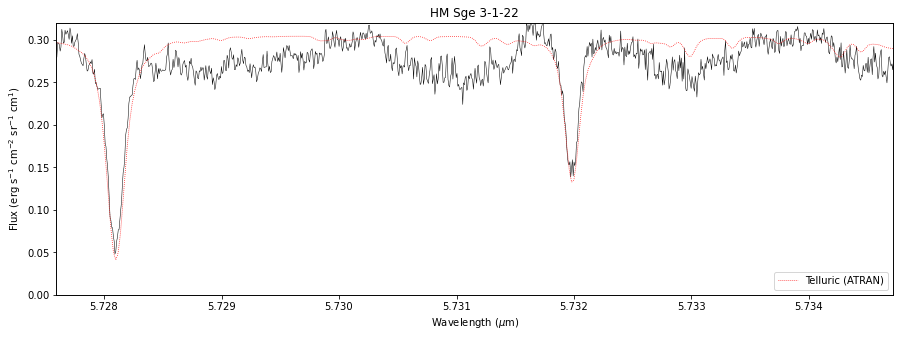

In [11]:
#Zoom in on m divisions of the spectrum

m = 4 #number of seperate plots
j = 0 #indexing value
frac = (maxW - minW)/m #width of each plot
while j < m:
    fig, ax1, ax2 = plot_window(minW + j*frac, minW + (j+1)*frac)
    ax1.set_ylim(0, .32) 
    ax1.set_xlim(minW + j*frac, minW + (j+1)*frac) 
    plt.show()
    j+=1

In [12]:
#Flux peaks

fluxPeakIndices, _ = sp.find_peaks(original_flux, height=.28, distance = 80)
print(fluxPeakIndices)
#fluxPeakVals = flux[fluxPeakIndices]
#print(fluxPeakVals)
fluxPeakWavelengths = wavelength_um[fluxPeakIndices]
print(fluxPeakWavelengths)

examplePeakWavelength = []

#Find notable features and programmatically determine their values
examplePeakWavelength.append(wavelength_um[fluxPeakIndices[-13]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[-15]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[-20]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[21]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[18]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[15]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[13]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[8]])

examplePeakWavelength.sort()

exampleIndicies = []
examplePeakValues = []
print("Wavelengths of Peaks in Order:", examplePeakWavelength)

for x in examplePeakWavelength:
    exampleIndicies.append(np.where(wavelength_um == x))

for x in exampleIndicies:
    examplePeakValues.append(flux[x][0])

print("Heights of Peaks in Order:", examplePeakValues)

[  85  277  436  595  696  833  921 1049 1144 1260 1355 1453 1600 1720
 1851 1962 2112 2199 2334 2414 2511 2637 2718 2844 3024 3204 3297 3420
 3527 3612 3693 3775 3886 3979 4162 4248 4441 4575 4675 4755 4865 5020
 5143 5242 5330 5439 5519]
[5.73912496 5.73778357 5.73667379 5.73556403 5.73485936 5.73390362
 5.73329004 5.73239779 5.7317352  5.73092082 5.73025857 5.72957564
 5.72854594 5.72771003 5.7267931  5.72601974 5.72497172 5.72436604
 5.72342619 5.72286642 5.72219125 5.72131444 5.72074869 5.71987233
 5.71861896 5.71736693 5.71672058 5.71586499 5.7151213  5.71453006
 5.71396088 5.713391   5.71261967 5.71196802 5.71069661 5.71009953
 5.70875456 5.70782022 5.70712593 5.70657054 5.705807   5.7047314
 5.70387821 5.70319123 5.70258102 5.7018249  5.70127015]
Wavelengths of Peaks in Order: [5.710696611574338, 5.712619666376596, 5.715864993110889, 5.721314438468911, 5.72342618879691, 5.726019741068157, 5.727710034679495, 5.731735201670039]
Heights of Peaks in Order: [0.3246653378009796, 0.31

In [13]:
#Water Troughs

water_model = np.transpose(water_model)

#print(water_model)
water = (-1*water_model["flux"])+1
#print(water)
waterTroughIndices, _ = sp.find_peaks(water, height = .01,distance = 50)
#print(waterTroughIndices)
waterTroughFlux = water[waterTroughIndices]
#print(waterTroughFlux)
waterPeakWavelength = water_model["wavelength_um"][waterTroughIndices]
#print(waterPeakWavelength)

exampleWaterWL=[]

#Find notable features and programmatically determine their values
for wl in waterPeakWavelength:
    if((wl> 5.711) & (wl < 5.7115)):
        exampleWaterWL.append(wl)
        break

for wl in waterPeakWavelength:
    if((wl> 5.7125) & (wl < 5.7135)):
        exampleWaterWL.append(wl)
        break

for wl in waterPeakWavelength:
    if((wl> 5.716) & (wl < 5.717)):
        exampleWaterWL.append(wl)
        break

for wl in waterPeakWavelength:
    if((wl> 5.7315) & (wl < 5.7325)):
        exampleWaterWL.append(wl)
        break

for wl in waterPeakWavelength:
    if((wl> 5.721) & (wl < 5.722)):
        exampleWaterWL.append(wl)
        break
    

for wl in waterPeakWavelength:
    if((wl> 5.7235) & (wl < 5.724)):
        exampleWaterWL.append(wl)
        break

for wl in waterPeakWavelength:
    if((wl> 5.726) & (wl < 5.727)):
        exampleWaterWL.append(wl)
        break

for wl in waterPeakWavelength:
    if((wl> 5.728) & (wl < 5.7285)):
        exampleWaterWL.append(wl)
        break

#Sort water values
exampleWaterWL.sort()

exampleWaterIndicies = []
waterTroughVals = []

#Find the indicies of the notable water features
for x in exampleWaterWL:
    exampleWaterIndicies.append([np.where(water_model["wavelength_um"] == x)])

print(exampleWaterWL)

[5.711068587763534, 5.7130634745444, 5.716232692538561, 5.721712759010923, 5.723825899468274, 5.726426861611996, 5.728108084248835, 5.73199488608383]


In [14]:
#Velocity calculation

#correction velocity
v_corrected = -19.35031 #from exes velocity shift program

#convert to m
fluxPeakWL = [EmissionWL * 10**-6 for EmissionWL in examplePeakWavelength]
waterTroughWL = [WaterWL *10**-6 for WaterWL in exampleWaterWL]

#difference of each water trough and flux peak
diff = list()
for w1, w2 in zip(fluxPeakWL, waterTroughWL):
    diff.append(w1-w2)

#velocity calculation
c = 3*(10**8)
totV = []
i = 0
while i < len(diff):
    totV.append(((diff[i]/waterTroughWL[i]) * c) /1000) #convert to km/s
    i+=1

correctedV = [x - v_corrected for x in totV]

print("Corrected velocities of lines = ",correctedV, "km/s")
print(sum(correctedV)/len(correctedV))

Corrected velocities of lines =  [-0.18944075655624104, -3.9546035432515225, 0.05266516382147657, -1.5343739462815549, -1.5995238201418047, -1.978201845737221, -1.4968648517408099, 5.758999176207263] km/s
-0.6176680529600518


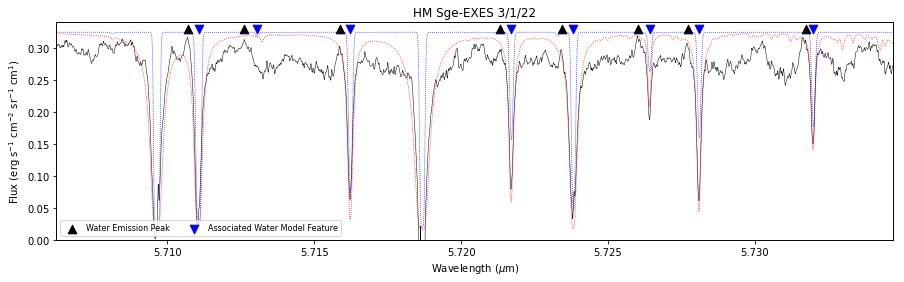

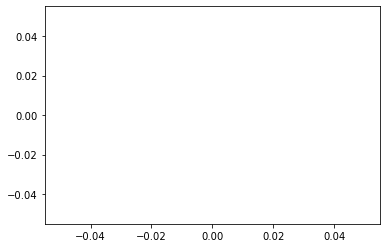

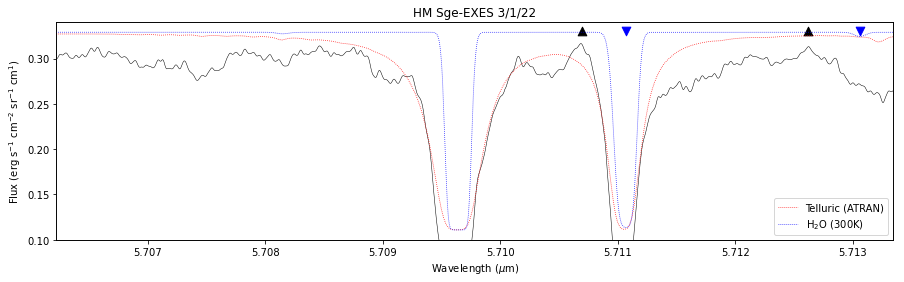

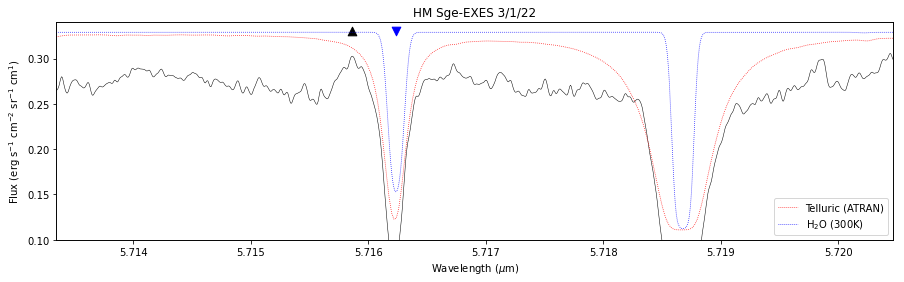

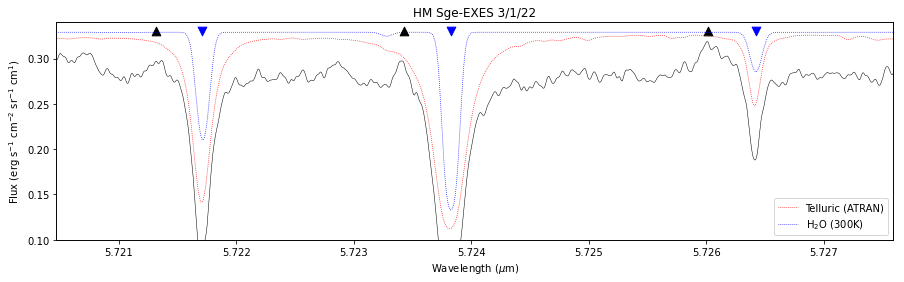

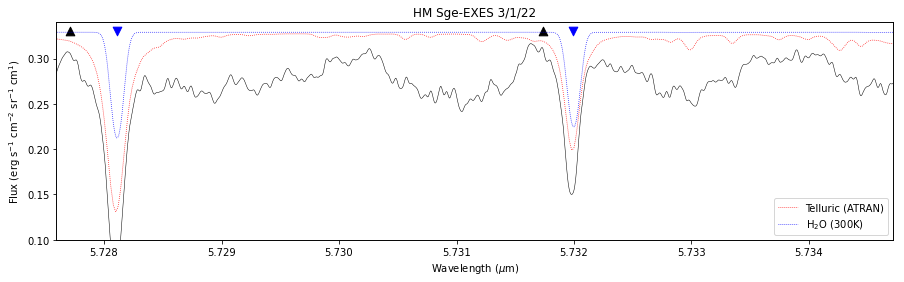

In [15]:
#correct for system velocities in the graph
#watergraph = water_model["wavelength_um"]*(v_corrected/300000) + water_model["wavelength_um"]
watergraph = water_model["wavelength_um"]

#Flux smoothing
flux = gauss_flux

def plot_window(xmin, xmax):
    #Create axes
    fig = plt.figure(figsize=(15, 4))
    ax1 = fig.add_subplot(1,1,1)
    
    #create second axis to overplot ATRAN
    ax2 = ax1.twinx()
    #hide axis labels and ticks
    ax2.set_yticks([])
    #plot data
    ax1.plot(wavelength_um, flux, lw=0.5, c="k")

    #plot Atmospheric model (ATRAN)
    ax2.plot(
        wavelength_um, atran, lw=0.75, c="r", linestyle=":", label="Telluric (ATRAN)"
    )

    #Setup water model plot
    ax2.plot(
        watergraph,
        water_model["flux"],
        lw=0.75,
        c="b",
        linestyle=":",
        label=r"H$_2$O (300K)",
    )

    #Plot labels
    ax1.set_ylabel(r"Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ cm$^{1}$)")
    ax1.set_xlabel(r"Wavelength ($\mu$m)")

    plt.legend(loc="lower right")
    plt.title("HM Sge-EXES 3/1/22")
    return fig, ax1, ax2

#Plot the full spectrum
minW = min(wavelength_um)+.005
maxW = max(wavelength_um)-.005

#Calls the previously created plot_window function and plots the full range of the data set
fig, ax1, ax2 = plot_window(5.8, 5.6) 

#marks the features on the plot
pointers = np.full(len(examplePeakWavelength),.33)

emission = ax1.scatter(examplePeakWavelength, pointers, s=75, c = "black", marker = "^")
trough = ax1.scatter(exampleWaterWL, pointers, s=75, c = "blue", marker = "v")

#Optional manual y range
ax1.set_ylim(0, .34) 
ax1.set_xlim(minW, maxW) 

plt.legend((emission, trough),
           ('Water Emission Peak', "Associated Water Model Feature"),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)


plt.show()
plt.plot()

#Zoom in on m divisions of the spectrum

m = 4 #number of seperate plots
j = 0 #indexing value
frac = (maxW - minW)/m #width of each plot
while j < m:
    fig, ax1, ax2 = plot_window(minW + j*frac, minW + (j+1)*frac)
    ax1.set_ylim(.1, .34) 
    ax1.set_xlim(minW + j*frac, minW + (j+1)*frac)
    pointers = np.full(len(examplePeakWavelength),.33)
    emission = ax1.scatter(examplePeakWavelength, pointers, s=75, c = "black", marker = "^")
    trough = ax1.scatter(exampleWaterWL, pointers, s=75, c = "blue", marker = "v")
    plt.show()
    j+=1

[0.05711069 0.05713063 0.05716233 0.05721713 0.05723826 0.05726427
 0.05728108 0.05731995]
[139.90244517795244, 139.84755639670257, 140.47023853442312, 141.92535764707392, 141.42173170055895, 142.1016607850011, 142.54183225512284, 140.33919264267521]
[3363.11886169312, 4950.933308532401, 3450.7673284565303, 3239.71673392223, 3064.04607900928, 3583.09669208099, 3064.0740318214002, 3784.29481814795]
[-1.03522367e-03  1.44756742e+02]
965.9748179797497


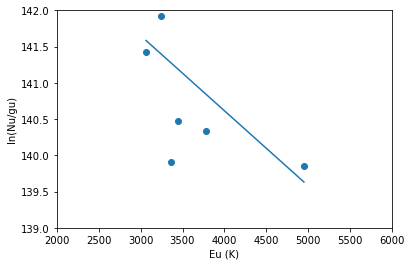

In [16]:
#Use hitran to make rotational diagrams

#Match the water model wavelengths to specific entries in the hitran table
tableWLs = []
for w in exampleWaterWL:
    tableWLs.append((min(hitran["Wavelength"], key=lambda x:abs(x-w))))

#print(tableWLs)

#find the indicies of those entries
tableIndicies = []
for x in tableWLs:
    tableIndicies.append(np.where(hitran["Wavelength"] == x)[0][0])

#print(tableIndicies)

waterWavelengthMeters =  np.dot(1/100,exampleWaterWL)
print(waterWavelengthMeters)
#Calculate the # of emitting molecules (Nu)
Nu = []
d = 3.2166*10**19 #distance (m)
i = 0
for x in tableIndicies:
    num = 4*math.pi*examplePeakValues[i]*(d**2)*waterWavelengthMeters[i]
    den = 3*(10**8)*hitran["A"][x]*6.62607015*(10**(-34))
    Nu.append(num/den)
    i=i+1

#Retrieve upper degeneracy from hitran
gu = []
for x in tableIndicies:
    gu.append(hitran["gu"][x])

#Retrieve upper energy from hitran
Eu = []
for x in tableIndicies:
    Eu.append(hitran["Eu(K)"][x])

#print(Nu)
#print(gu)

#Calculate the number of emitting molecules over the upper state degeneracy
numDegen = []
j = 0
for x in Nu:
    z = Nu[j]/gu[j]
    numDegen.append(math.log(z))
    j=j+1

print(numDegen)
print(Eu)

x = Eu
y = numDegen
plt.scatter(x, y)
plt.ylabel("ln(Nu/gu)")
plt.xlabel("Eu (K)")
plt.xlim([2000, 6000])
plt.ylim([139,142])

#fit a line to the data to find temperature
mb = np.polyfit(x, y, 1)
print(mb)
m = -1/mb[0]
print(m)
plt.plot(np.unique(x), np.poly1d(mb)(np.unique(x)))
plt.show()

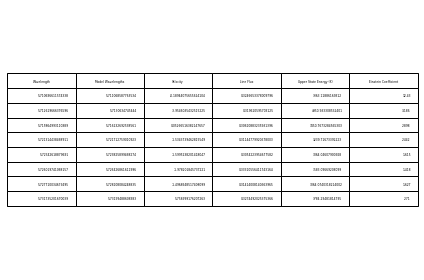

In [17]:
#Tabulated values

#define figure and axes
fig, ax = plt.subplots()

#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

#Einstein Coeff
A = []
for x in tableIndicies:
    A.append(hitran["A"][x])
#create data
df = pd.DataFrame(np.transpose([examplePeakWavelength,  exampleWaterWL, correctedV, examplePeakValues, Eu, A]), columns=["Wavelength", "Model Wavelengths", "Velocity", "Line Flux", "Upper State Energy (K)", "Einstein Coefficient"])

#create table
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')

#display table
fig.tight_layout()
plt.show()

df.to_csv('3_1.csv')